# Определение уровня шума аэродинамического профиля

## Техническое задание

Исходные данные:

1. Частота [Гц].
2. Угол атаки [град].
3. Длина хорды аэродинамического профиля [м].
4. Скорость набегающего потока [м/с].
5. Толщина аэродинамического профиля [м].

Результирующие данные:

6. Масштабированный уровень звукового давления [Дб].

Требования:

1. mae <= 10 [db] for regretion model

# Импорт библиотек

## Стандартные библиотеки

Python

In [1]:
import sys
import os
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sklern

In [2]:
import sklearn

print(sklearn.__version__)

1.4.2


tensorflow

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, Input, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import activations
from tensorflow import optimizers

print(tf.__version__)

2.16.1


## Частные библиотеки

In [4]:
sys.path.append('D:/Programming/Python')

In [5]:
from tools import export2, rounding
from decorators import timeit
from ml_tools import SCALERS, DataFrame, Model
from dl_tools import training_plot, predictions_plot

# Определение констант

# Импорт исходных данных

In [6]:
os.listdir()

['airfoil_self_noise.dat',
 'app.py',
 'home.html',
 'Airfoil Self-Noise - UCI Machine Learning Repository.html',
 'airfoil_noise.ipynb',
 'exports',
 'checkpoints',
 '.git',
 'log.csv',
 '.ipynb_checkpoints',
 'model_sklearn.pkl',
 'model_tf.keras',
 'model_airfoil_noise.pkl',
 '.gitignore']

In [7]:
df = DataFrame(pd.read_csv("airfoil_self_noise.dat", sep="\t", header=None))
df

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [8]:
df.info(memory_usage=True)

<class 'ml_tools.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1503 non-null   int64  
 1   1       1503 non-null   float64
 2   2       1503 non-null   float64
 3   3       1503 non-null   float64
 4   4       1503 non-null   float64
 5   5       1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


# Обработка данных

## Предварительная обработка

In [9]:
df.columns = ["Frequency [Hz]", "Attack angle [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Thickness [m]", "Pressure level [db]"]

In [10]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [11]:
target = 'Pressure level [db]'

## Обработка типов данных

In [12]:
df.dtypes

Frequency [Hz]                  int64
Attack angle [deg]            float64
Chord length [m]              float64
Free-stream velocity [m/s]    float64
Thickness [m]                 float64
Pressure level [db]           float64
dtype: object

In [13]:
categorials = df.select_dtypes(['object']).columns.to_list()
print(f'Категориальные признаки: {categorials}')

Категориальные признаки: []


In [14]:
all(map(lambda tp: 'bool' in str(tp).lower() or 'int' in str(tp).lower() or 'float' in str(tp).lower(), df.dtypes))

True

## Обработка локальных пустот

In [15]:
df.isna().sum()

Frequency [Hz]                0
Attack angle [deg]            0
Chord length [m]              0
Free-stream velocity [m/s]    0
Thickness [m]                 0
Pressure level [db]           0
dtype: int64

In [16]:
if not all(df.isna().sum()): df.dropna(axis=0, inplace=True)

In [17]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Обработка сбалансированности

In [18]:
df.shape

(1503, 6)

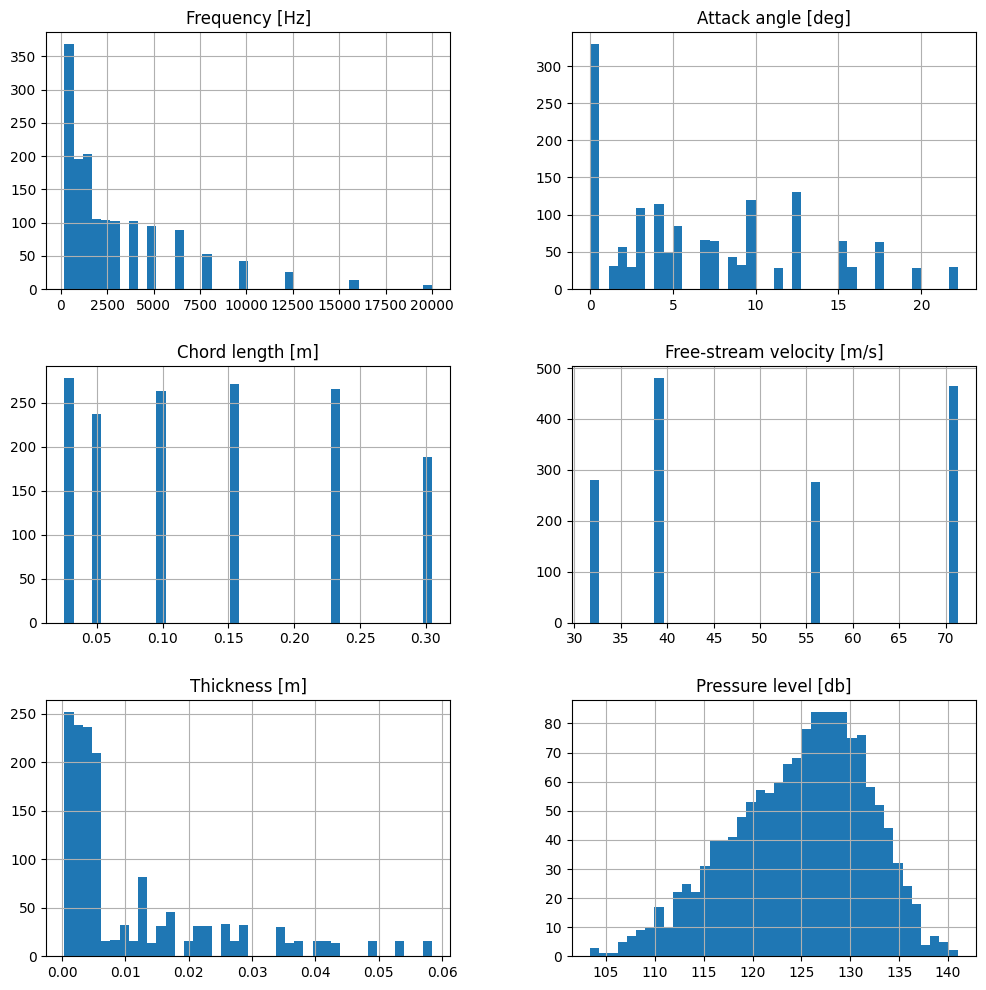

In [19]:
df.histplot(figsize=(12, 12), bins=40)

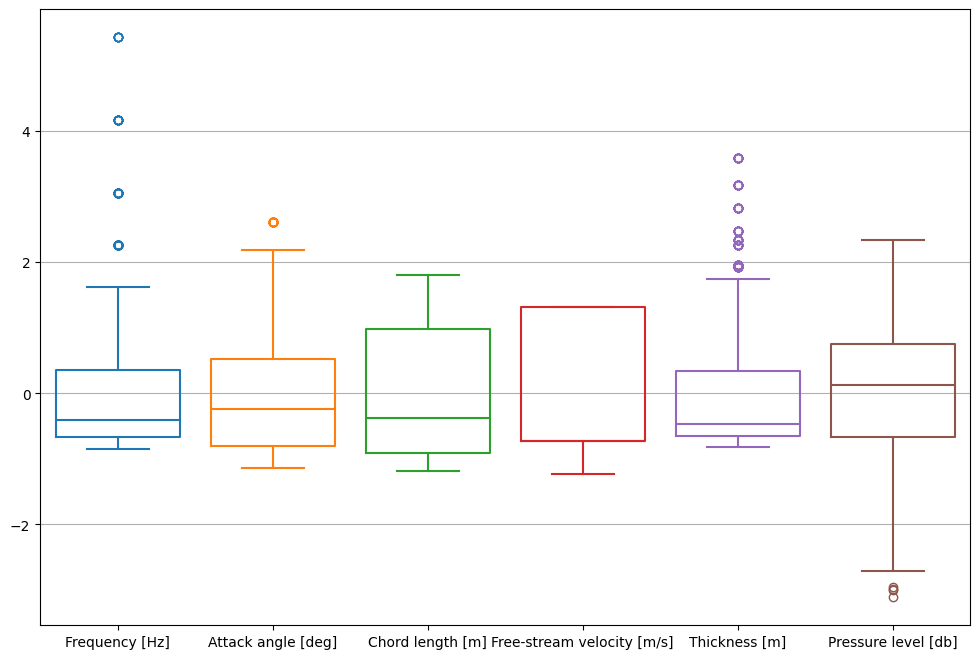

In [20]:
df.boxplot(figsize=(12, 8), title='', scale=True, fill=False, grid=True, savefig=False)

In [98]:
df.balance(target)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
Pressure level [db],,,,,
103.380,1,1,1,1,1
104.130,1,1,1,1,1
104.204,1,1,1,1,1
104.500,1,1,1,1,1
106.111,1,1,1,1,1
...,...,...,...,...,...
139.438,1,1,1,1,1
139.808,1,1,1,1,1
139.918,1,1,1,1,1


In [21]:
def check_class_balance(df, column_name, threshhold=0.8):
    a = df[column_name].value_counts()
    balance_ratio = a.min() / a.max()
    return balance_ratio, balance_ratio <= threshhold

In [22]:
df.columns

Index(['Frequency [Hz]', 'Attack angle [deg]', 'Chord length [m]',
       'Free-stream velocity [m/s]', 'Thickness [m]', 'Pressure level [db]'],
      dtype='object')

In [23]:
check_class_balance(df, 'Frequency [Hz]')

(0.05714285714285714, True)

# Анализ данных

In [24]:
df.detect_outliers('3sigma')

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
28,12500,0.0,0.3048,55.5,0.002831,111.076
47,12500,0.0,0.3048,39.6,0.003101,109.619
78,12500,1.5,0.3048,71.3,0.003367,109.222
...,...,...,...,...,...,...
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224
1502,6300,15.6,0.1016,39.6,0.052849,104.204
723,5000,12.6,0.1524,39.6,0.058411,104.130


In [25]:
df.detect_outliers('Tukey')

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
11,10000,0.0,0.3048,71.3,0.002663,115.391
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
27,10000,0.0,0.3048,55.5,0.002831,113.076
28,12500,0.0,0.3048,55.5,0.002831,111.076
...,...,...,...,...,...,...
1502,6300,15.6,0.1016,39.6,0.052849,104.204
722,4000,12.6,0.1524,39.6,0.058411,104.500
723,5000,12.6,0.1524,39.6,0.058411,104.130
724,6300,12.6,0.1524,39.6,0.058411,103.380


In [26]:
#df = df.drop(detect_outliers(df, '3sigma').index)

In [27]:
'''for i in range(len(data.columns)-1):
    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='reg')
    plt.show()'''

"for i in range(len(data.columns)-1):\n    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='reg')\n    plt.show()"

In [28]:
'''for i in range(len(data.columns)-1):
    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='kde')
    plt.show()'''

"for i in range(len(data.columns)-1):\n    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='kde')\n    plt.show()"

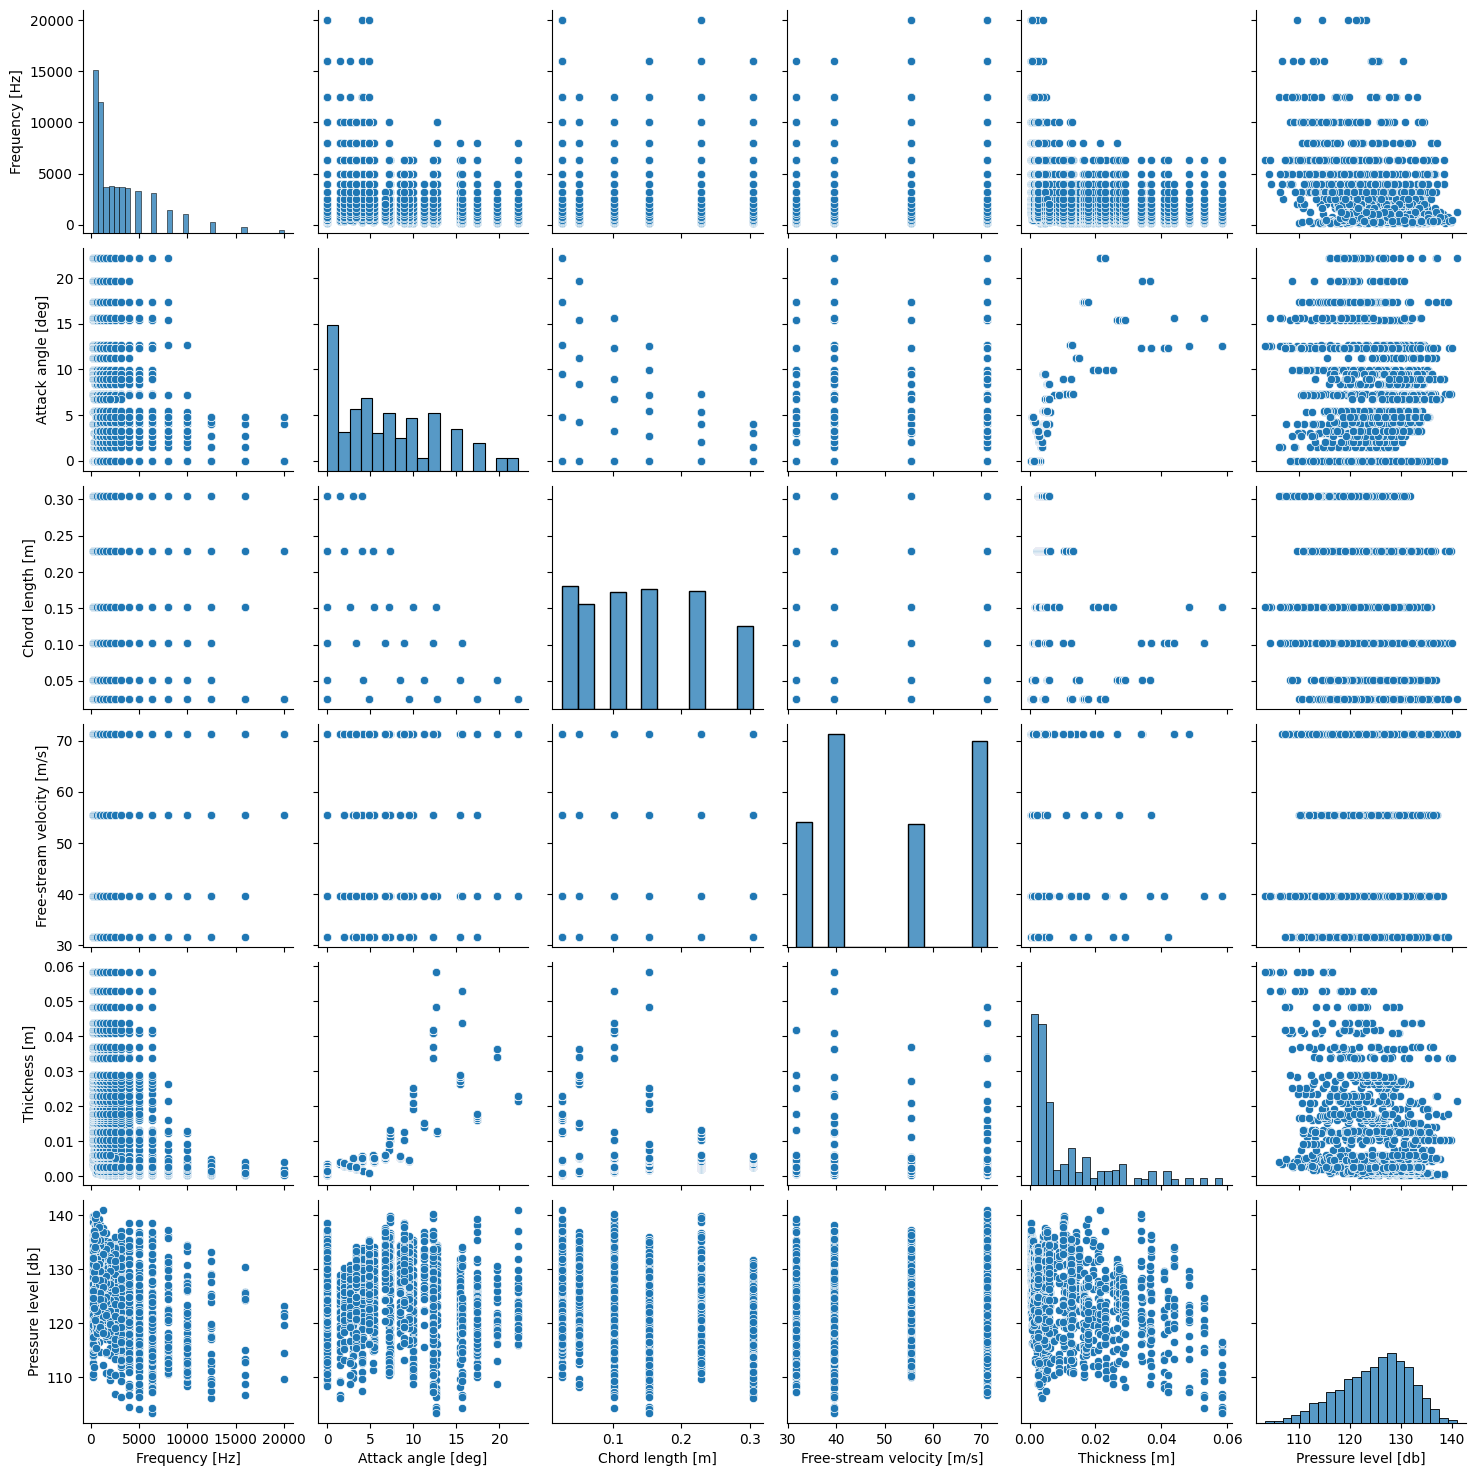

In [29]:
sns.pairplot(df);

In [30]:
#df.pairplot(figsize=(15, 15), savefig=False)

# Корреляция данных

In [31]:
corr = df.corr()

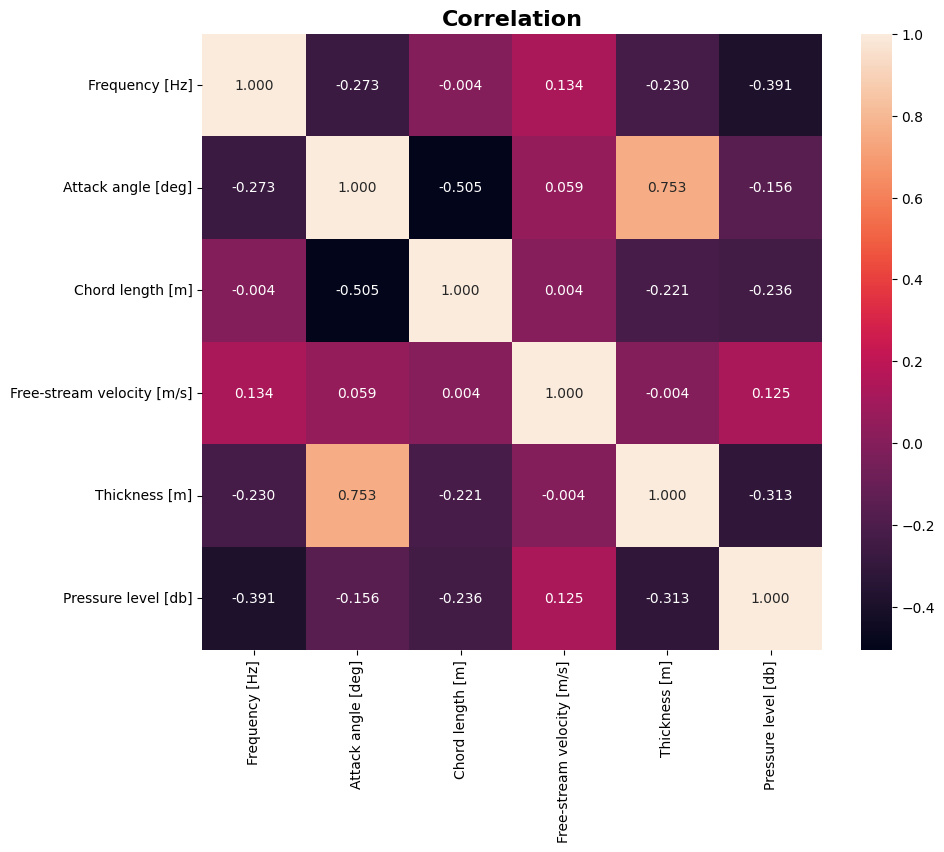

In [32]:
df.corrplot(figsize=(10, 8), title='Correlation', fmt=3, savefig=False)

In [33]:
corr_features = df.find_corr_features(threshold=0.85)
print(f'Линейно зависимые признаки: {corr_features}')

Линейно зависимые признаки: []


In [34]:
df.drop(corr_features, axis=1, inplace=True)
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Диапазон коэффициента L1-регуляризации

In [35]:
l1 = list(2 ** np.linspace(-10, 2, 100))

In [36]:
df.l1_importance(target, l1=l1, scale=True, early_stopping=True)

Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 792.31it/s]


,L1,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,0.000977,-4.038949,-2.492871,-3.334658,1.553049,-1.936845
1,0.001062,-4.038779,-2.492594,-3.334439,1.552923,-1.936882
2,0.001155,-4.038593,-2.492293,-3.334202,1.552787,-1.936921
3,0.001257,-4.038392,-2.491965,-3.333943,1.552638,-1.936964
4,0.001367,-4.038172,-2.491609,-3.333662,1.552476,-1.937010
...,...,...,...,...,...,...
95,2.858288,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
96,3.108813,NaN,NaN,NaN,NaN,NaN
97,3.381295,NaN,NaN,NaN,NaN,NaN
98,3.677659,NaN,NaN,NaN,NaN,NaN


Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 893.93it/s]


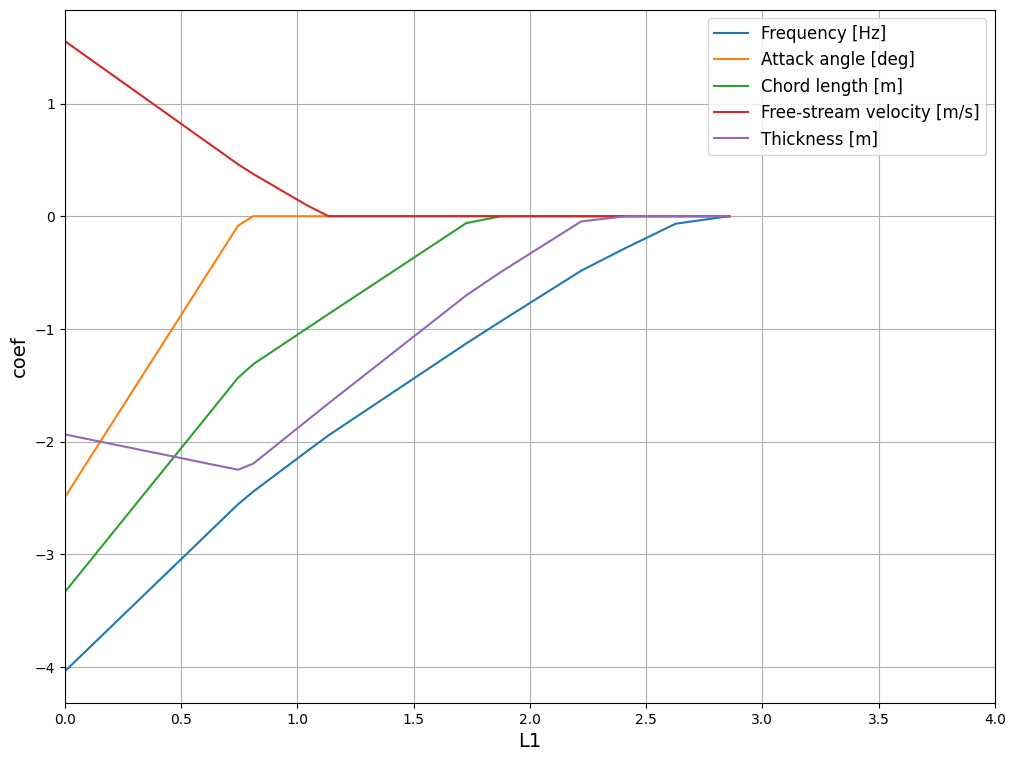

In [37]:
df.l1_importance_plot(target, l1=l1, scale=True, early_stopping=True)

Убираем первые обнуившиеся признаки

In [38]:
mutual_info_score = df.mutual_info_score(target)
mutual_info_score

{'Thickness [m]': 4.6024596809735305,
 'Attack angle [deg]': 2.980876741183215,
 'Frequency [Hz]': 2.876180968192246,
 'Chord length [m]': 1.7541634258473542,
 'Free-stream velocity [m/s]': 1.3276544292818262}

In [39]:
df.permutation_importance(target)

Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [40]:
df.permutation_importance_plot(target, figsize=(12, 9))

Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [41]:
df.feature_importances(target)

Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [42]:
df.feature_importances_plot(target, figsize=(9,9))

Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


## Анализ необходимости нормализации и скалирования

In [43]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Frequency [Hz],1503.0,2886.380572,3152.573137,200.000000,800.000000,1600.000000,4000.000000,20000.000000
Attack angle [deg],1503.0,6.782302,5.918128,0.000000,2.000000,5.400000,9.900000,22.200000
Chord length [m],1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
Free-stream velocity [m/s],1503.0,50.860745,15.572784,31.700000,39.600000,39.600000,71.300000,71.300000
Thickness [m],1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
Pressure level [db],1503.0,124.835943,6.898657,103.380000,120.191000,125.721000,129.995500,140.987000


In [44]:
scaler = SCALERS[1]()
scaler

StandardScaler()

In [45]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [46]:
pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,-0.662023,-1.146403,1.799299,1.312935,-0.644805,0.197939
1,-0.598561,-1.146403,1.799299,1.312935,-0.644805,0.052935
2,-0.519235,-1.146403,1.799299,1.312935,-0.644805,0.161688
3,-0.408177,-1.146403,1.799299,1.312935,-0.644805,0.399494
4,-0.281255,-1.146403,1.799299,1.312935,-0.644805,0.380644
...,...,...,...,...,...,...
1498,-0.122601,1.490443,-0.373740,-0.723345,3.172773,-2.112990
1499,0.083648,1.490443,-0.373740,-0.723345,3.172773,-2.259444
1500,0.353359,1.490443,-0.373740,-0.723345,3.172773,-2.643705
1501,0.670666,1.490443,-0.373740,-0.723345,3.172773,-2.698806


# Разделение данных для обучения и тестирования

In [47]:
test_size = 0.2
shuffle = True
random_state = 0

In [48]:
train_df, test_df = df.train_test_split(test_size=test_size, shuffle=shuffle, random_state=random_state)

In [97]:
train_df.shape, test_df.shape

((1202, 6), (301, 6))

# Разделение данных на признаки и целевую функцию

In [50]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

In [51]:
pd.concat([train_features, train_labels], axis=1)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
1058,800,9.5,0.0254,71.3,0.004207,127.206
408,315,7.3,0.2286,55.5,0.011171,136.284
703,2000,12.6,0.1524,71.3,0.048316,117.504
1279,8000,0.0,0.1016,39.6,0.001463,122.341
140,6300,3.0,0.3048,39.6,0.004957,114.042
...,...,...,...,...,...,...
763,12500,0.0,0.0508,39.6,0.000792,123.988
835,1250,8.4,0.0508,31.7,0.005808,130.156
1216,1250,22.2,0.0254,71.3,0.021418,140.987
559,1250,5.4,0.1524,55.5,0.004333,130.777


# Классическое ML

## Поиск лучшей модели

Определение объекта модели

In [52]:
model = Model(None)

In [53]:
models = model.fit_all(train_features, train_labels, exceptions=False)

100%|██████████| 48/48 [00:02<00:00, 21.58it/s]


In [54]:
warnings.filterwarnings('ignore')

errors, scores = dict(), dict()

for model in tqdm(models):
    try:
        predictions = model.predict(test_features)
        errors[str(model)] = model.errors(test_labels, predictions, exceptions=False)
        scores[str(model)] = model.scores(test_labels, predictions, exceptions=False)
    except:
        pass    
    
warnings.filterwarnings('default')

100%|██████████| 29/29 [00:01<00:00, 22.20it/s]


In [55]:
errors = pd.DataFrame(errors)
errors

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,KNeighborsRegressor(),RadiusNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,123.802246,3.545248,3.691568,4.455010,4.454955,3.545248,4.455010,4.775870,3.551563,4.934883,...,4.724528,NaN,1.688010,1.922113,1.233265,1.057754,1.403399,1.938778,3.214041,1.221394
mean_squared_error,15374.035087,20.765101,22.319791,32.184320,32.086592,20.765101,32.184320,39.243295,20.793224,36.923887,...,37.545406,NaN,5.519008,7.473976,3.142246,2.278598,3.757953,6.866024,15.857207,3.155005
root_mean_squared_error,123.992077,4.556874,4.724383,5.673123,5.664503,4.556874,5.673123,6.264447,4.559959,6.076503,...,6.127431,NaN,2.349257,2.733857,1.772638,1.509503,1.938544,2.620310,3.982111,1.776233
max_error,137.758000,15.344562,14.958278,16.823379,16.818112,15.344562,16.823381,19.395758,15.234636,16.863000,...,17.553000,NaN,13.590000,17.346000,10.384770,7.757780,9.517400,10.790129,10.224878,9.351129
mean_absolute_percentage_error,0.991962,0.028530,0.029844,0.036146,0.036139,0.028530,0.036146,0.038925,0.028589,0.040157,...,0.038280,NaN,0.013629,0.015498,0.009959,0.008550,0.011328,0.015564,0.026035,0.009853
median_absolute_error,124.951000,2.758977,3.058168,3.575059,3.591656,2.758977,3.575061,3.788477,2.789413,4.043117,...,3.662800,NaN,1.360000,1.380000,0.949080,0.755350,1.104100,1.443202,2.674533,0.844990
mean_squared_log_error,17.142996,0.001321,0.001445,0.002108,0.002101,0.001321,0.002108,0.002584,0.001324,0.002424,...,0.002445,NaN,0.000350,0.000480,0.000198,0.000146,0.000238,0.000431,0.001025,0.000199
root_mean_squared_log_error,4.140410,0.036350,0.038013,0.045912,0.045833,0.036350,0.045912,0.050833,0.036393,0.049235,...,0.049444,NaN,0.018715,0.021908,0.014084,0.012085,0.015420,0.020754,0.032016,0.014109


In [56]:
scores = pd.DataFrame(scores)
scores

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,KNeighborsRegressor(),RadiusNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
r2_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,2.018241e-01,NaN,8.826717e-01,8.411111e-01,0.933199,0.951559,0.920110,8.540355e-01,6.628924e-01,0.932928
d2_absolute_error_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.144663e-01,NaN,6.836108e-01,6.397321e-01,0.768845,0.801742,0.736956,6.366085e-01,3.975818e-01,0.771070
rand_score,0.000000,1.000000,1.000000,9.992248e-01,9.992248e-01,1.000000,9.992248e-01,9.453378e-01,1.000000,9.901883e-01,...,9.986268e-01,NaN,9.988704e-01,9.988483e-01,1.000000,1.000000,1.000000,9.998893e-01,9.826135e-01,1.000000
adjusted_rand_score,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,...,0.000000e+00,NaN,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
completeness_score,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000
homogeneity_score,0.000000,1.000000,1.000000,9.743739e-01,9.743739e-01,1.000000,9.743739e-01,5.116095e-01,1.000000,7.782914e-01,...,9.552037e-01,NaN,9.618575e-01,9.636693e-01,1.000000,1.000000,1.000000,9.959650e-01,7.542810e-01,1.000000
v_measure_score,0.000000,1.000000,1.000000,9.870206e-01,9.870206e-01,1.000000,9.870206e-01,6.769070e-01,1.000000,8.753249e-01,...,9.770887e-01,NaN,9.805580e-01,9.814986e-01,1.000000,1.000000,1.000000,9.979784e-01,8.599318e-01,1.000000
d2_tweedie_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,2.018241e-01,NaN,8.826717e-01,8.411111e-01,0.933199,0.951559,0.920110,8.540355e-01,6.628924e-01,0.932928
d2_pinball_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.144663e-01,NaN,6.836108e-01,6.397321e-01,0.768845,0.801742,0.736956,6.366085e-01,3.975818e-01,0.771070
mutual_info_score,0.000000,5.707110,5.707110,5.560859e+00,5.560859e+00,5.707110,5.560859e+00,2.919812e+00,5.707110,4.441795e+00,...,5.451453e+00,NaN,5.489427e+00,5.499767e+00,5.707110,5.707110,5.707110,5.684082e+00,4.304765e+00,5.707110


In [57]:
stats = pd.concat([errors, scores], axis=0)
stats

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,KNeighborsRegressor(),RadiusNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,123.802246,3.545248,3.691568,4.455010e+00,4.454955e+00,3.545248,4.455010e+00,4.775870e+00,3.551563,4.934883e+00,...,4.724528e+00,NaN,1.688010e+00,1.922113e+00,1.233265,1.057754,1.403399,1.938778e+00,3.214041e+00,1.221394
mean_squared_error,15374.035087,20.765101,22.319791,3.218432e+01,3.208659e+01,20.765101,3.218432e+01,3.924329e+01,20.793224,3.692389e+01,...,3.754541e+01,NaN,5.519008e+00,7.473976e+00,3.142246,2.278598,3.757953,6.866024e+00,1.585721e+01,3.155005
root_mean_squared_error,123.992077,4.556874,4.724383,5.673123e+00,5.664503e+00,4.556874,5.673123e+00,6.264447e+00,4.559959,6.076503e+00,...,6.127431e+00,NaN,2.349257e+00,2.733857e+00,1.772638,1.509503,1.938544,2.620310e+00,3.982111e+00,1.776233
max_error,137.758000,15.344562,14.958278,1.682338e+01,1.681811e+01,15.344562,1.682338e+01,1.939576e+01,15.234636,1.686300e+01,...,1.755300e+01,NaN,1.359000e+01,1.734600e+01,10.384770,7.757780,9.517400,1.079013e+01,1.022488e+01,9.351129
mean_absolute_percentage_error,0.991962,0.028530,0.029844,3.614626e-02,3.613933e-02,0.028530,3.614626e-02,3.892451e-02,0.028589,4.015658e-02,...,3.828003e-02,NaN,1.362922e-02,1.549829e-02,0.009959,0.008550,0.011328,1.556414e-02,2.603491e-02,0.009853
median_absolute_error,124.951000,2.758977,3.058168,3.575059e+00,3.591656e+00,2.758977,3.575061e+00,3.788477e+00,2.789413,4.043117e+00,...,3.662800e+00,NaN,1.360000e+00,1.380000e+00,0.949080,0.755350,1.104100,1.443202e+00,2.674533e+00,0.844990
mean_squared_log_error,17.142996,0.001321,0.001445,2.107916e-03,2.100638e-03,0.001321,2.107916e-03,2.584038e-03,0.001324,2.424084e-03,...,2.444724e-03,NaN,3.502364e-04,4.799585e-04,0.000198,0.000146,0.000238,4.307142e-04,1.025006e-03,0.000199
root_mean_squared_log_error,4.140410,0.036350,0.038013,4.591204e-02,4.583271e-02,0.036350,4.591204e-02,5.083343e-02,0.036393,4.923499e-02,...,4.944415e-02,NaN,1.871460e-02,2.190795e-02,0.014084,0.012085,0.015420,2.075366e-02,3.201572e-02,0.014109
r2_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,2.018241e-01,NaN,8.826717e-01,8.411111e-01,0.933199,0.951559,0.920110,8.540355e-01,6.628924e-01,0.932928
d2_absolute_error_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.144663e-01,NaN,6.836108e-01,6.397321e-01,0.768845,0.801742,0.736956,6.366085e-01,3.975818e-01,0.771070


Удаление неподходящих моделей с отрицательными метриками

In [58]:
stats = stats.transpose()
stats = stats[(stats >= 0).all(axis=1)]
stats = stats.transpose()
stats

,LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),RANSACRegressor(),...,TheilSenRegressor(),KNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,3.545248,3.691568,4.455010e+00,4.454955e+00,3.545248,4.455010e+00,4.775870e+00,3.551563,4.934883e+00,3.934622,...,3.628365,4.724528e+00,1.688010e+00,1.922113e+00,1.233265,1.057754,1.403399,1.938778e+00,3.214041e+00,1.221394
mean_squared_error,20.765101,22.319791,3.218432e+01,3.208659e+01,20.765101,3.218432e+01,3.924329e+01,20.793224,3.692389e+01,32.824028,...,24.338733,3.754541e+01,5.519008e+00,7.473976e+00,3.142246,2.278598,3.757953,6.866024e+00,1.585721e+01,3.155005
root_mean_squared_error,4.556874,4.724383,5.673123e+00,5.664503e+00,4.556874,5.673123e+00,6.264447e+00,4.559959,6.076503e+00,5.729226,...,4.933430,6.127431e+00,2.349257e+00,2.733857e+00,1.772638,1.509503,1.938544,2.620310e+00,3.982111e+00,1.776233
max_error,15.344562,14.958278,1.682338e+01,1.681811e+01,15.344562,1.682338e+01,1.939576e+01,15.234636,1.686300e+01,26.275904,...,19.117432,1.755300e+01,1.359000e+01,1.734600e+01,10.384770,7.757780,9.517400,1.079013e+01,1.022488e+01,9.351129
mean_absolute_percentage_error,0.028530,0.029844,3.614626e-02,3.613933e-02,0.028530,3.614626e-02,3.892451e-02,0.028589,4.015658e-02,0.031711,...,0.029173,3.828003e-02,1.362922e-02,1.549829e-02,0.009959,0.008550,0.011328,1.556414e-02,2.603491e-02,0.009853
median_absolute_error,2.758977,3.058168,3.575059e+00,3.591656e+00,2.758977,3.575061e+00,3.788477e+00,2.789413,4.043117e+00,2.582314,...,2.956483,3.662800e+00,1.360000e+00,1.380000e+00,0.949080,0.755350,1.104100,1.443202e+00,2.674533e+00,0.844990
mean_squared_log_error,0.001321,0.001445,2.107916e-03,2.100638e-03,0.001321,2.107916e-03,2.584038e-03,0.001324,2.424084e-03,0.002229,...,0.001588,2.444724e-03,3.502364e-04,4.799585e-04,0.000198,0.000146,0.000238,4.307142e-04,1.025006e-03,0.000199
root_mean_squared_log_error,0.036350,0.038013,4.591204e-02,4.583271e-02,0.036350,4.591204e-02,5.083343e-02,0.036393,4.923499e-02,0.047210,...,0.039850,4.944415e-02,1.871460e-02,2.190795e-02,0.014084,0.012085,0.015420,2.075366e-02,3.201572e-02,0.014109
r2_score,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,0.302196,...,0.482584,2.018241e-01,8.826717e-01,8.411111e-01,0.933199,0.951559,0.920110,8.540355e-01,6.628924e-01,0.932928
d2_absolute_error_score,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,0.262521,...,0.319924,1.144663e-01,6.836108e-01,6.397321e-01,0.768845,0.801742,0.736956,6.366085e-01,3.975818e-01,0.771070


In [59]:
cmap = sns.color_palette('coolwarm', as_cmap=True)
stats.style.background_gradient(cmap=cmap)

,LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),RANSACRegressor(),PoissonRegressor(),HuberRegressor(),TweedieRegressor(),QuantileRegressor(),TheilSenRegressor(),KNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,3.545248,3.691568,4.455010,4.454955,3.545248,4.455010,4.775870,3.551563,4.934883,3.934622,3.960220,5.154495,4.446718,4.784956,3.628365,4.724528,1.688010,1.922113,1.233265,1.057754,1.403399,1.938778,3.214041,1.221394
mean_squared_error,20.765101,22.319791,32.184320,32.086592,20.765101,32.184320,39.243295,20.793224,36.923887,32.824028,25.430791,42.962856,31.879186,40.029213,24.338733,37.545406,5.519008,7.473976,3.142246,2.278598,3.757953,6.866024,15.857207,3.155005
root_mean_squared_error,4.556874,4.724383,5.673123,5.664503,4.556874,5.673123,6.264447,4.559959,6.076503,5.729226,5.042895,6.554606,5.646166,6.326864,4.933430,6.127431,2.349257,2.733857,1.772638,1.509503,1.938544,2.620310,3.982111,1.776233
max_error,15.344562,14.958278,16.823379,16.818112,15.344562,16.823381,19.395758,15.234636,16.863000,26.275904,15.494579,20.291632,16.777574,18.913384,19.117432,17.553000,13.590000,17.346000,10.384770,7.757780,9.517400,10.790129,10.224878,9.351129
mean_absolute_percentage_error,0.028530,0.029844,0.036146,0.036139,0.028530,0.036146,0.038925,0.028589,0.040157,0.031711,0.032104,0.041608,0.036066,0.038962,0.029173,0.038280,0.013629,0.015498,0.009959,0.008550,0.011328,0.015564,0.026035,0.009853
median_absolute_error,2.758977,3.058168,3.575059,3.591656,2.758977,3.575061,3.788477,2.789413,4.043117,2.582314,3.263319,4.286890,3.676287,3.675391,2.956483,3.662800,1.360000,1.380000,0.949080,0.755350,1.104100,1.443202,2.674533,0.844990
mean_squared_log_error,0.001321,0.001445,0.002108,0.002101,0.001321,0.002108,0.002584,0.001324,0.002424,0.002229,0.001660,0.002809,0.002086,0.002645,0.001588,0.002445,0.000350,0.000480,0.000198,0.000146,0.000238,0.000431,0.001025,0.000199
root_mean_squared_log_error,0.036350,0.038013,0.045912,0.045833,0.036350,0.045912,0.050833,0.036393,0.049235,0.047210,0.040740,0.052998,0.045675,0.051432,0.039850,0.049444,0.018715,0.021908,0.014084,0.012085,0.015420,0.020754,0.032016,0.014109
r2_score,0.558556,0.525505,0.315795,0.317873,0.558556,0.315795,0.165729,0.557958,0.215037,0.302196,0.459368,0.086655,0.322282,0.149021,0.482584,0.201824,0.882672,0.841111,0.933199,0.951559,0.920110,0.854036,0.662892,0.932928
d2_absolute_error_score,0.335503,0.308077,0.164983,0.164993,0.335503,0.164983,0.104843,0.334319,0.075039,0.262521,0.257723,0.033876,0.166537,0.103140,0.319924,0.114466,0.683611,0.639732,0.768845,0.801742,0.736956,0.636608,0.397582,0.771070


In [60]:
for i, model in enumerate(models):
    if str(model) in stats.columns:
        print(f'{i}) {model}')

1) LinearRegression()
2) Ridge()
3) Lasso()
4) ElasticNet()
5) Lars()
6) LassoLars()
7) OrthogonalMatchingPursuit()
8) BayesianRidge()
9) ARDRegression()
11) RANSACRegressor()
13) PoissonRegressor()
14) HuberRegressor()
15) TweedieRegressor()
16) QuantileRegressor()
17) TheilSenRegressor()
19) KNeighborsRegressor()
21) DecisionTreeRegressor()
22) ExtraTreeRegressor()
23) RandomForestRegressor()
24) ExtraTreesRegressor()
25) BaggingRegressor()
26) GradientBoostingRegressor()
27) AdaBoostRegressor()
28) HistGradientBoostingRegressor()


In [61]:
model = Model(models[25]())
model()

BaggingRegressor()

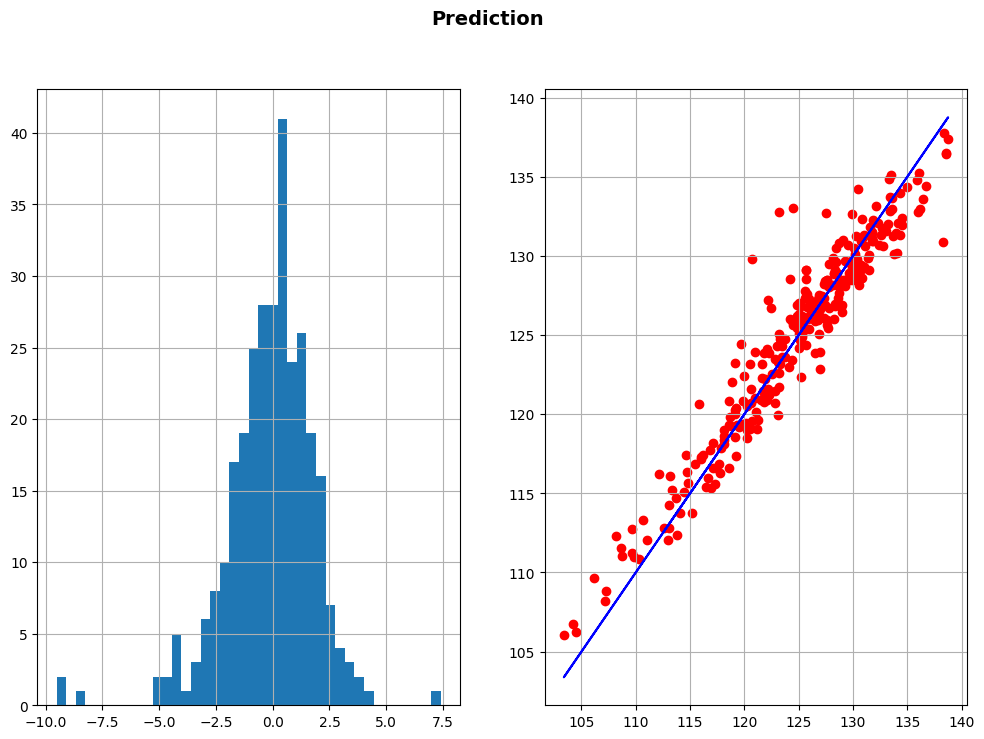

In [62]:
model.prediction(test_labels, model.predict(test_features))

In [63]:
model.plot_tree(feature_columns=train_features.columns)

The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got BaggingRegressor() instead.


## Смещение, весовые коэффициенты и уравнение

In [64]:
model.intercept_

'BaggingRegressor' object has no attribute 'intercept_'


In [65]:
model.coef_

'BaggingRegressor' object has no attribute 'coef_'


In [66]:
model.expression

'BaggingRegressor' object has no attribute 'intercept_'
'BaggingRegressor' object has no attribute 'coef_'
'NoneType' object is not iterable


# Экспорт модели

In [67]:
model.save('model_sklearn.pkl')
model()

D:\Programming/Python\ml_tools.py:489: ResourceWarning: unclosed file <_io.BufferedWriter name='model_sklearn.pkl'>
  pickle.dump(self.__model, open(path, 'wb'))


BaggingRegressor()

# Нейронная сеть

# Определение последовательности обучения

In [68]:
normalizer = Normalization(axis=-1)
normalizer

<Normalization name=normalization, built=False>

In [69]:
normalizer.adapt(np.array(df.drop([target], axis=1)))

In [70]:
model = Sequential()

model.add(Input(shape=(len(df.columns)-1,)))
model.add(normalizer)
model.add(layers.Flatten())
#model.add(layers.Dense(units=64, activation=activations.relu, input_shape=[len(train_df.keys())]))
#model.add(layers.Dense(units=64, activation=activations.relu))
model.add(layers.Dense(units=1))

In [71]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (72.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 11 (48.00 B)

# Компиляция модели

tf.optimizers.

1) SGD  # Классический оптимизатор, который обновляет веса в направлении антиградиента функции потерь
2) Adam  # Оптимизатор, сочетающий в себе преимущества адаптивного градиентного спуска (Adagrad) и Root Mean Square Propagation (RMSprop).
3) RMSprop  # Оптимизатор адаптирует скорость обучения для каждого параметра на основе истории градиентов для этого параметра.
4) Adagrad  # Оптимизатор уменьшает скорость обучения для параметров, которые редко или никогда не обновлялись, и увеличивает скорость обучения для параметров, которые часто обновлялись
5) Adadelta  # Оптимизатор является расширением Adagrad и использует только последние градиенты для обновления параметров.
6) Adamax  # Оптимизатор является вариантом Adam, который использует бесконечную норму вместо L2 нормы для обновления параметров.
6) Nadam  # Оптимизатор является комбинацией методов Nesterov Accelerated Gradient (NAG) и Adam

In [72]:
learning_rate = 0.1
optimizer = optimizers.Adam(learning_rate=learning_rate)
loss = 'mae'
metrics =  ['mae', 'mse']

In [73]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

# Обучение модели

In [74]:
epochs = 100
batch_size = 32
verbose = False  # динамическое прогресс

monitor = 'loss' # что мониторить
min_delta = 0.01 # сравнивать с каким значением
patience = 5 # в течении скольких эпох

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose),
             keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
             keras.callbacks.TerminateOnNaN()]

In [75]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    validation_data=(test_features, test_labels),
    #validation_split = 0.2,  # данные ранее не были разделены на тренировочные и тестовые
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=verbose)

CPU times: total: 10.1 s
Wall time: 7.66 s


# Анализ обучения

In [76]:
max(history.epoch)

40

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/training_plot.png" file exporting

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/training_plot.png" file has created!
"export2" elapsed 1.1165 seconds


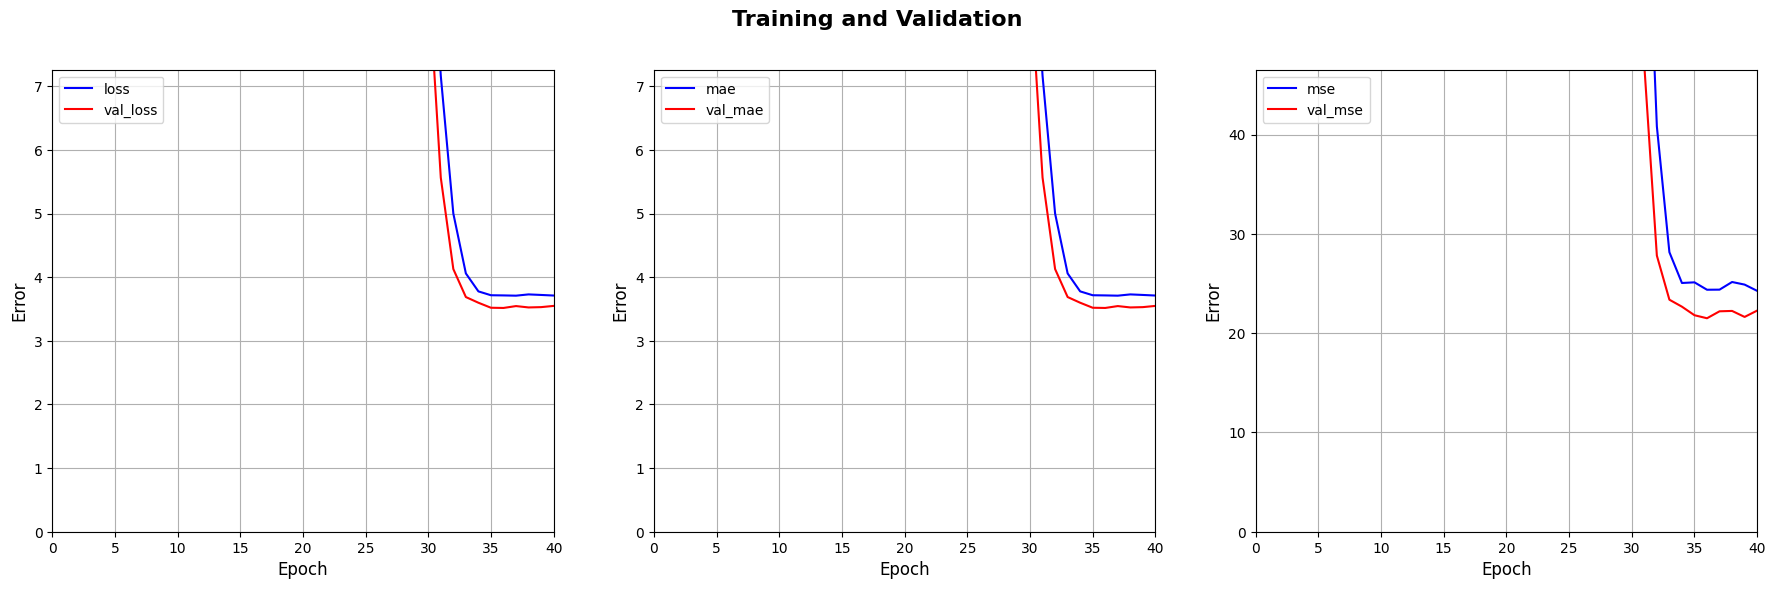

In [77]:
training_plot(history, figsize=(22, 6), savefig=True)

In [78]:
hist = pd.DataFrame(history.history)
hist.index.rename('epoch', inplace=True)
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
epoch,,,,,,
36,3.714511,3.714511,24.379854,3.517388,3.517388,21.506895
37,3.710488,3.710488,24.389477,3.546976,3.546976,22.207342
38,3.730501,3.730501,25.159576,3.525544,3.525544,22.244633
39,3.721879,3.721879,24.897432,3.530419,3.530419,21.640881
40,3.712671,3.712671,24.267202,3.549561,3.549561,22.279474


Оценка производительности модели

In [79]:
test_results = dict()
test_results['model'] = model.evaluate(test_features, test_labels, verbose=0)

In [80]:
test_results

{'model': [3.5495612621307373, 3.5495612621307373, 22.27947425842285]}

In [81]:
test_predictions = model.predict(test_features.to_numpy()).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/predictions_plot.png" file exporting

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/predictions_plot.png" file has created!
"export2" elapsed 0.5567 seconds


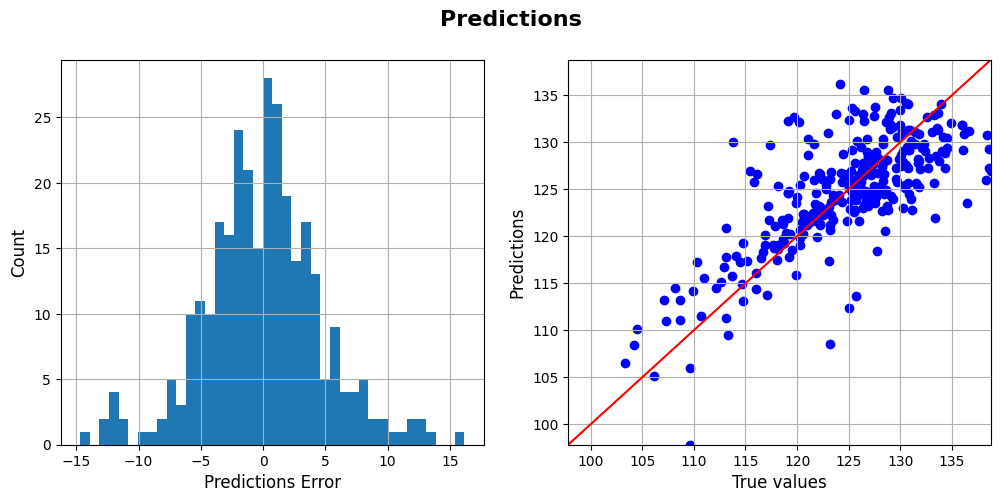

In [82]:
predictions_plot(test_labels, test_predictions, figsize=(12, 5), savefig=True)

# Экспорт модели

In [83]:
model_name = 'model_tf'
model_name += '.keras'

In [84]:
if model_name not in os.listdir(): 
    model.save(model_name)
    print('model has saved')
else:
    print('model has not saved!')

model has not saved!


In [85]:
os.path.exists(model_name)

True

In [86]:
model.save(model_name)

# Тестирование

# Импорт модели

In [87]:
os.listdir()

['airfoil_self_noise.dat',
 'app.py',
 'home.html',
 'Airfoil Self-Noise - UCI Machine Learning Repository.html',
 'airfoil_noise.ipynb',
 'exports',
 'checkpoints',
 '.git',
 'log.csv',
 '.ipynb_checkpoints',
 'model_sklearn.pkl',
 'model_tf.keras',
 'model_airfoil_noise.pkl',
 '.gitignore']

In [88]:
model_sklearn = Model().load('model_sklearn.pkl')
model_tf = keras.models.load_model('model_tf.keras')

D:\Programming/Python\ml_tools.py:492: ResourceWarning: unclosed file <_io.BufferedReader name='model_sklearn.pkl'>
  self.__model = pickle.load(open(path, 'rb'))


## Автоматическое тестирование

In [89]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_sklearn.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

,Pressure level [db],Predicted Pressure level [db]
0,126.201,126.8933
1,125.201,126.8339
2,125.951,126.1116
3,127.591,127.2941
4,127.461,126.8842
...,...,...
1498,110.264,110.1422
1499,109.254,109.6873
1500,106.604,106.8893
1501,106.224,106.5190


In [90]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_tf.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Pressure level [db],Predicted Pressure level [db]
0,126.201,127.270592
1,125.201,126.951057
2,125.951,126.551636
3,127.591,125.992447
4,127.461,125.353378
...,...,...
1498,110.264,114.458557
1499,109.254,113.420067
1500,106.604,112.062042
1501,106.224,110.464371


## Ручное тестирование

In [91]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [92]:
airfoil_props = {"Frequency [Hz]": [1000], 
                 "Attack angle [deg]": [4], 
                 "Chord length [m]" : [0.2], 
                 "Free-stream velocity [m/s]": [40], 
                 "Thickness [m]": [0.09]}
airfoil_props = pd.DataFrame(airfoil_props)
airfoil_props

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,1000,4,0.2,40,0.09


In [93]:
%%time
for predict in model_tf.predict(airfoil_props.to_numpy()):
    print(f'Pressure level [db]: {predict[0]} ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Pressure level [db]: 110.561279296875 
CPU times: total: 109 ms
Wall time: 89 ms


In [94]:
pd.concat([airfoil_props, pd.DataFrame(model_sklearn.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

c:\Python\Python 3.11.9\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,1000,4,0.2,40,0.09,117.3959


In [95]:
pd.concat([airfoil_props, pd.DataFrame(model_tf.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,1000,4,0.2,40,0.09,110.561279


# Экспорт лучшей модели

In [96]:
model_sklearn.save('model_airfoil_noise.pkl')

D:\Programming/Python\ml_tools.py:489: ResourceWarning: unclosed file <_io.BufferedWriter name='model_airfoil_noise.pkl'>
  pickle.dump(self.__model, open(path, 'wb'))
